In [ ]:
# default_exp datasets
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# Stanford Large Network Datasets with Ground-truth Communities

In this notebook, we will download some Directed Network Datasets with Ground-truth Communities from [Stanford Larget Network Dataset Collection](https://snap.stanford.edu/data/) and visualize them to build intuition about communities.

## Email network [email-Eu-core network](https://snap.stanford.edu/data/email-Eu-core.html)

The [email-Eu-core network](https://snap.stanford.edu/data/email-Eu-core.html) was generated from the email exchanges within a large European research institution. Each node represents an individual, and a directional edge from one individual to another represents some email exchanges between them in the specified direction. Each individual belongs to exactly one of 42 departments in the institution.

In [ ]:
# export
import os
import torch
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import sort_edge_index

class EmailEuNetwork(InMemoryDataset):
  def __init__(self, transform=None, pre_transform=None):
    super().__init__("./datasets/email_Eu_network", transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return ["email-Eu-core.txt", "email-Eu-core-department-labels.txt"]

  @property
  def processed_file_names(self):
    pre_transformed = '' if self.pre_transform is None else '_pre-transformed'
    return [f"email-Eu-network{pre_transformed}.pt", "never-skip-processing"]

  def download(self):
    for filename in self.raw_file_names:
      download_url(f"https://snap.stanford.edu/data/{filename}.gz", self.raw_dir)
      extract_gz(f"{self.raw_dir}/{filename}.gz", self.processed_dir)
      os.remove(f"{self.raw_dir}/{filename}.gz")

  def process(self):
    # Graph connectivity
    with open(self.raw_paths[0], "r") as f:
      edge_array = [[int(x) for x in line.split()] for line in f.read().splitlines()]
    edge_index = torch.t(torch.tensor(edge_array))
    edge_index = sort_edge_index(edge_index)
    # Ground-truth label
    with open(self.raw_paths[1], "r") as f:
      label_array = [[int(x) for x in line.split()] for line in f.read().splitlines()]
    y = torch.tensor(label_array)
    # Node identity features
    x = torch.eye(y.size(0), dtype=torch.float)
    # Build and save data
    data = Data(x=x, edge_index=edge_index, y=y)
    if self.pre_transform is not None:
      data = self.pre_transform(data)
    self.data, self.slices = self.collate([data])
    torch.save((self.data, self.slices), self.processed_paths[0])

Now it should be easy to download and extract the email network dataset.

In [ ]:
from directed_graphs.datasets import EmailEuNetwork
dataset = EmailEuNetwork(transform=None, pre_transform=None)
data = dataset[0] # there is only graph in this dataset

c:\Users\nhiin\Downloads\Anaconda\envs\sumry-directed-graphs\lib\site-packages\torch_geometric\data\dataset.py:150: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to sure to delete 'datasets\email_Eu_network\processed' first
  warnings.warn(
Processing...
Done!


Let print out some information about this dataset.

In [ ]:
# hide_input
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Is directed: {data.is_directed()}")
print(f"Is coalesced: {data.is_coalesced()}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")

Number of nodes: 1005
Number of edges: 25571
Average node degree: 25.44
Is directed: True
Is coalesced: True
Has isolated nodes: True
Has self-loops: True


Let try to visualize this network using a simple heat map of the directed adjacency matrix. The nodes are ordered by the ground-truth communities. Intuitively, we would think that there would be more edges within a community than across communities. This phenomenon is definitely visible in the heatmap. In addition, although this directed adjacency matrix is definitely not symmetrical, the heat map does appear to be in some sense close to symmetrical.

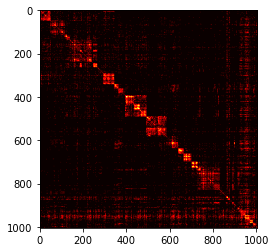

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

def visualize_heatmap(edge_index, order_ind):
  dense_adj = to_dense_adj(edge_index)[0]
  plt.imshow(dense_adj[order_ind,:][:,order_ind], cmap="hot")
  plt.show()

order_ind = torch.argsort(data.y[:,1])
visualize_heatmap(data.edge_index, order_ind)

## Add source and sink communities

In a directed graph, a node is a source if it has in-degree of 0, and a node is a sink if it has out-degree of 0. These notions can be generalized into source communities and sink communities (by communities we simply mean a group of nodes in the directed graph). If we think of information on the directed graph as some mass diffusing through random walk, then mass will stay in the sink communities once enter and mass will stay out of the source communities once exit. Then, the existence of source and/or sink communities could imbalancedly affect the measurement of diffusion curvature.

In order to assess and possibly correct this effect, we first want to create directed graphs with source and/or sink communities. We will do so by create pretransformation to existing directed graph data so to make all edges connected to some ground-truth communities pointing outwards (for source communities) or inwards (for sink communities). 

We will be flexible and add a parameter `adv_prob` to indicate the probability of edges pointing in the _wrong_ direction. This probability should be zero or close to zero.

There are two possible way to _correct_ the edges that point in the wrong direction: either by reversing the direction or by removing the edge completely. The probability of employing these methods is specified by the probability `remove_prob`. This parameter could help mitigate the effect of excessive number of edges pointing out of (into resp.) source (sink resp.) communities.

In [ ]:
# export
import warnings
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import sort_edge_index

class SourceSink(BaseTransform):
  def __init__(self, prob_source=0.1, prob_sink=0.1, adv_prob=0, remove_prob=0):
    if prob_source + prob_sink > 1:
      warnings.warn("Total probability of source and sink exceeds 1")
      excess = prob_source + prob_sink - 1
      prob_source -= excess/2
      prob_sink -= excess/2
      warnings.warn(f"Adjusted: prob_source = {prob_source}, prob_sink = {prob_sink}")
    self.prob_source = prob_source
    self.prob_sink = prob_sink
    self.adv_prob = adv_prob
    self.remove_prob = remove_prob
  
  def _has_ground_truth(self, data):
    return data.y is not None and data.y.shape == (data.num_nodes, 2)

  def _wrong_direction(self, labels, sources, sinks, tail, head):
    return (labels[head] in sources and labels[tail] not in sources) \
          or (labels[tail] in sinks and labels[head] not in sinks)
  
  def __call__(self, data):
    if self._has_ground_truth(data):
      # get ground truth labels
      y = data.y[torch.argsort(data.y[:,0]),:]
      classes = y[:,1].unique()
      # randomly choose source and sink classes
      mask = torch.rand(len(classes))
      source_classes = classes[mask < self.prob_source]
      sink_classes = classes[mask > 1 - self.prob_sink]
      # add source/sink ground-truth label
      y = torch.hstack((y, torch.t(torch.tensor([[1 if c in source_classes else -1 if c in sink_classes else 0 for c in y[:,1]]]))))
      labels = y[:,1]
      sources = source_classes
      sinks = sink_classes
    else:
      warnings.warn("Data has no groud-truth labels")
      # randomly choose source and sink nodes
      nodes = torch.arange(data.num_nodes)
      mask = torch.rand(data.num_nodes)
      source_nodes = nodes[mask < self.prob_source]
      sink_nodes = nodes[mask > 1 - self.prob_sink]
      # add source/sink ground-truth label
      y = torch.tensor([[n, 1 if n in source_nodes else -1 if n in sink_nodes else 0] for n in nodes])
      labels = nodes
      sources = source_nodes
      sinks = sink_nodes
    
    # correct improper edges
    edge_array = []
    for e in range(data.num_edges):
      tail, head = data.edge_index[:,e]
      if self._wrong_direction(labels, sources, sinks, tail, head) and torch.rand(1)[0] > self.adv_prob:
        if torch.rand(1)[0] < self.remove_prob: # remove the improper edge
          continue
        else: # reverse the improper edge
          edge_array.append([head, tail])
      else: # keep proper edge
        edge_array.append([tail, head])
    edge_index = torch.t(torch.tensor(edge_array))
    data.edge_index = sort_edge_index(edge_index)
    data.y = y
    return data

Let try applying a transformation to the Email Network.

In [ ]:
from directed_graphs.datasets import EmailEuNetwork, SourceSink
pre_transform = SourceSink(prob_source=0.3, prob_sink=0.2, adv_prob=0, remove_prob=0.1)
dataset = EmailEuNetwork(transform=None, pre_transform=pre_transform)
data = dataset[0]

c:\Users\nhiin\Downloads\Anaconda\envs\sumry-directed-graphs\lib\site-packages\torch_geometric\data\dataset.py:150: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to sure to delete 'datasets\email_Eu_network\processed' first
  warnings.warn(
Processing...
Done!


We print the information about this data again. We would expect all information to stay the same except that there should be around 10% fewer edges.

In [ ]:
# hide_input
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Is directed: {data.is_directed()}")
print(f"Is coalesced: {data.is_coalesced()}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")

Number of nodes: 1005
Number of edges: 25056
Average node degree: 24.93
Is directed: True
Is coalesced: False
Has isolated nodes: True
Has self-loops: True


Let try visualize this new network, where the nodes are first ordered by ground-truth source/sink and then by ground-truth communities. The heat map now look much more clearly asymetrical, specifically with fewer edges in the lower triangular and more edges in the upper triangular. The transformation is supposed to turn the first 30% of the nodes into source communities and the last 20% of the nodes into sink communities. Indeed, there is no edges coming from the last 70% of the nodes into the first 30% of the nodes, and there is no edges coming from the last 20% of the nodes into the first 80% of the nodes.

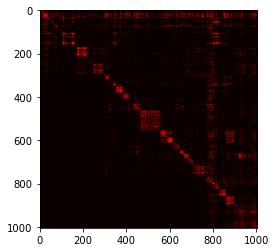

In [ ]:
import torch

order_ind = torch.argsort(data.y[:,1] + data.y[:,2]*data.num_nodes, descending=True)
visualize_heatmap(data.edge_index, order_ind)